In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import product
import pickle
import os
import random
import sqlite3
from scipy import stats

np.set_printoptions(precision=3)

In [2]:
class Agent:
    def __init__(self):
        pass
    
    def actNaively(self):
        return 4
                 
    def actRules(self, state, rules):
        # Extract state variables
        tyre, condition, weather, radius, laps_cleared = state

        # Find bin number
        radius_bin = radius // 50 - 12
        if radius_bin == 12:
            radius_bin = 11
        
        # Check if laps_cleared is beyond the no_change_after_lap
        if laps_cleared >= rules[radius_bin]["no_change_after_lap"]:
            return 4
        
        # If tire condition is below a threshold
        if condition < rules[radius_bin]["condThreshold"]:
            if "Dry" in weather:
                # For dry weather, prioritize ultrasoft
                return 0
            elif "Wet" in weather:
                wetness = int(weather.split('%')[0])  # Extract the wetness percentage
                # if under threshold A, use soft
                if wetness <= rules[radius_bin]["weatherThreshold1"]:
                    return 1
                # if under threshold B, use intermediate
                elif wetness <= rules[radius_bin]["weatherThreshold2"]:
                    return 2  
                # else, use fullwet
                else:
                    return 3
        
        # If none of the above conditions apply, continue without changing tires
        return 4


In [3]:
class Car:
    def __init__(self, tyre="Intermediate"):
        self.default_tyre = tyre
        self.possible_tyres = ["Ultrasoft", "Soft", "Intermediate", "Fullwet"]
        self.pitstop_time = 23
        self.reset()
    
    
    def reset(self):
        self.change_tyre(self.default_tyre)
    
    
    def degrade(self, w, r):
        if self.tyre == "Ultrasoft":
            self.condition *= (1 - 0.0050*w - (2500-r)/90000)
        elif self.tyre == "Soft":
            self.condition *= (1 - 0.0051*w - (2500-r)/93000)
        elif self.tyre == "Intermediate":
            self.condition *= (1 - 0.0052*abs(0.5-w) - (2500-r)/95000)
        elif self.tyre == "Fullwet":
            self.condition *= (1 - 0.0053*(1-w) - (2500-r)/97000)
        
        
    def change_tyre(self, new_tyre):
        assert new_tyre in self.possible_tyres
        self.tyre = new_tyre
        self.condition = 1.00
    
    
    def get_velocity(self):
        if self.tyre == "Ultrasoft":
            vel = 80.7*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Soft":
            vel = 80.1*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Intermediate":
            vel = 79.5*(0.2 + 0.8*self.condition**1.5)
        elif self.tyre == "Fullwet":
            vel = 79.0*(0.2 + 0.8*self.condition**1.5)
        return vel

    
class Track:
    def __init__(self, car=Car()):
        # self.radius and self.cur_weather are defined in self.reset()
        self.total_laps = 162
        self.car = car
        self.possible_weather = ["Dry", "20% Wet", "40% Wet", "60% Wet", "80% Wet", "100% Wet"]
        self.wetness = {
            "Dry": 0.00, "20% Wet": 0.20, "40% Wet": 0.40, "60% Wet": 0.60, "80% Wet": 0.80, "100% Wet": 1.00
        }
        self.p_transition = {
            "Dry": {
                "Dry": 0.987, "20% Wet": 0.013, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "20% Wet": {
                "Dry": 0.012, "20% Wet": 0.975, "40% Wet": 0.013, "60% Wet": 0.000, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "40% Wet": {
                "Dry": 0.000, "20% Wet": 0.012, "40% Wet": 0.975, "60% Wet": 0.013, "80% Wet": 0.000, "100% Wet": 0.000
            },
            "60% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.012, "60% Wet": 0.975, "80% Wet": 0.013, "100% Wet": 0.000
            },
            "80% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.012, "80% Wet": 0.975, "100% Wet": 0.013
            },
            "100% Wet": {
                "Dry": 0.000, "20% Wet": 0.000, "40% Wet": 0.000, "60% Wet": 0.000, "80% Wet": 0.012, "100% Wet": 0.988
            }
        }
        self.reset()
    
    
    def reset(self):
        self.radius = np.random.randint(600,1201)
        # self.cur_weather = np.random.choice(self.possible_weather)
        # self.radius = 900 #NOTE
        self.cur_weather = np.random.choice(self.possible_weather)        
        self.is_done = False
        self.pitstop = False
        self.laps_cleared = 0
        self.car.reset()
        return self._get_state()
    
    
    def _get_state(self):
        return [self.car.tyre, self.car.condition, self.cur_weather, self.radius, self.laps_cleared]
        
    
    def transition(self, action=0):
        """
        Args:
            action (int):
                0. Make a pitstop and fit new ‘Ultrasoft’ tyres
                1. Make a pitstop and fit new ‘Soft’ tyres
                2. Make a pitstop and fit new ‘Intermediate’ tyres
                3. Make a pitstop and fit new ‘Fullwet’ tyres
                4. Continue the next lap without changing tyres
        """
        ## Pitstop time will be added on the first eight of the subsequent lap
        time_taken = 0
        if self.laps_cleared == int(self.laps_cleared):
            if self.pitstop:
                self.car.change_tyre(self.committed_tyre)
                time_taken += self.car.pitstop_time
                self.pitstop = False
        
        ## The environment is coded such that only an action taken at the start of the three-quarters mark of each lap matters
        if self.laps_cleared - int(self.laps_cleared) == 0.75:
            if action < 4:
                self.pitstop = True
                self.committed_tyre = self.car.possible_tyres[action]
            else:
                self.pitstop = False
        
        self.cur_weather = np.random.choice(
            self.possible_weather, p=list(self.p_transition[self.cur_weather].values())
        )
        
        # we assume that degration happens only after a car has travelled the one-eighth lap
        velocity = self.car.get_velocity()
        time_taken += (2*np.pi*self.radius/8) / velocity
        reward = 0 - time_taken
        self.car.degrade(
            w=self.wetness[self.cur_weather], r=self.radius
        )
        self.laps_cleared += 0.125
        
        if self.laps_cleared == self.total_laps:
            self.is_done = True
        
        next_state = self._get_state()
        return reward, next_state, self.is_done, velocity

In [4]:
new_car = Car()
env = Track(new_car)

agent = Agent()

#### Naive agent
<br> lets see how an agent performs when it does not make any pitstops

In [5]:
#Sanity check

state = env.reset()    
done = False
G = 0
while not done:
    action = agent.actNaively()
    reward, next_state, done, velocity = env.transition(action)
    # added velocity for sanity check
    state = deepcopy(next_state)
    G += reward

print("G: %d" % G)

G: -45689


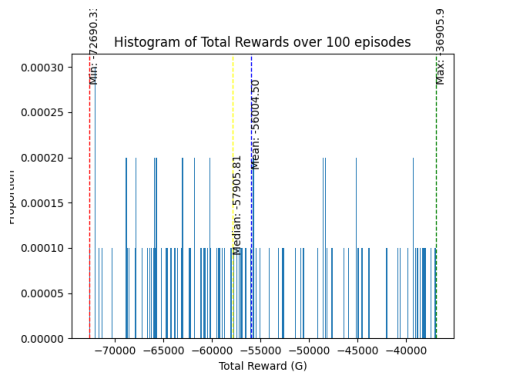

In [6]:
import os
import matplotlib.image as mpimg

# Path to save the histogram plot
filename = "rulesbased/sanity_check_histogram_rand.png"

# Check if the saved plot exists
if os.path.exists(filename):
    # Load and display the saved plot
    img = mpimg.imread(filename)
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
else:
    # Process and save the plot as it doesn't exist yet
    num_episodes = 100
    bin_size = 100
    G_values = []

    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        done = False
        G = 0
        while not done:
            action = agent.actNaively()
            reward, next_state, done, velocity = env.transition(action)
            state = deepcopy(next_state)
            G += reward
        G_values.append(G)

    # Calculate statistics
    min_val = min(G_values)
    max_val = max(G_values)
    mean_val = np.mean(G_values)
    median_val = np.median(G_values)  # Calculating the median

    # Create histogram with proportions
    plt.hist(G_values, bins=np.arange(min(G_values), max(G_values) + bin_size, bin_size), density=True)
    plt.xlabel('Total Reward (G)')
    plt.ylabel('Proportion')
    plt.title(f"Histogram of Total Rewards over {num_episodes} episodes")

    # Add vertical lines and annotations
    plt.axvline(min_val, color='red', linestyle='dashed', linewidth=1)
    plt.text(min_val, plt.ylim()[1]*0.9, 'Min: {:.2f}'.format(min_val), rotation=90)

    plt.axvline(max_val, color='green', linestyle='dashed', linewidth=1)
    plt.text(max_val, plt.ylim()[1]*0.9, 'Max: {:.2f}'.format(max_val), rotation=90)

    plt.axvline(mean_val, color='blue', linestyle='dashed', linewidth=1)
    plt.text(mean_val, plt.ylim()[1]*0.6, 'Mean: {:.2f}'.format(mean_val), rotation=90)

    plt.axvline(median_val, color='yellow', linestyle='dashed', linewidth=1)
    plt.text(median_val, plt.ylim()[1]*0.3, 'Median: {:.2f}'.format(median_val), rotation=90)

    # Save the plot
    plt.savefig(filename)

    plt.show()


## Rules Based iteration

we iterate through the different radius bins. For each bin, we use grid search to find its unique thresholds to be used in the rules. For each combination of thresholds in the grid search, we iterate through 100 simulations of random weather and random radius (within the radius bins interval). This way, we can find the set of thresholds that is not overfitted to just one weather sequence or one radius.

In [6]:
import os
import pickle
from tqdm import tqdm
from copy import deepcopy

# RULES BASED GRID_SEARCH

# Define the directory and file path for the pickled conditions
directory = "rulesbased"
if not os.path.exists(directory):
    os.makedirs(directory)
pickle_file_path = os.path.join(directory, "gridsearch_results_rand_radius_final.pkl")

new_car = Car()
env = Track(new_car)

agentNum = 100
conds = {}
rules = {}

for radius in tqdm(range(625, 1200, 50)):

    # find bin number
    radius_bin = radius // 50 - 12
    conds[radius_bin] = {}

    # for each thresholds
    for no_change_lap in list(range(160, 162, 1)):
        for cond in range(75, 90, 1):
            cond = cond / 100
            for wt1 in [20, 40]:
                for wt2 in [60, 80]:
                    
                    if wt2 < wt1: 
                        continue
                    
                    G_res = []
                    rules[radius_bin] = {
                            "condThreshold":cond,
                            "weatherThreshold1":wt1,
                            "weatherThreshold2":wt2,
                            "no_change_after_lap":no_change_lap
                    }
                    
                    for _ in range(agentNum): 
                        agent = Agent()
                        state = env.reset()
                    
                        iteration_radius = radius + random.randint(0,49) - 25 # randomize radius within the bin
                        env.radius = iteration_radius 
                        state[3] = iteration_radius
                        done = False
                        G = 0
                        i = 0
                        while not done:
                            action = agent.actRules(state, rules=rules)
                            reward, next_state, done, velocity = env.transition(action)
                            state = deepcopy(next_state)
                            G += reward
                            i += 1
                        
                        G /= env.radius # we look at reward per radius as radius israndomized within its bin
                        G_res.append(G)

                    conds[radius_bin][(cond, wt1, wt2, no_change_lap)] = sum(G_res) / len(G_res) # take the average reward of the 100 runs


# Save the generated conditions to a pickle file
with open(pickle_file_path, 'wb') as f:
    pickle.dump(conds, f)


100%|██████████| 12/12 [1:02:40<00:00, 313.41s/it]


#### Print the rules

In [7]:
best_rules = {}
for radius_bin in range(len(conds)):
    max_key = max(conds[radius_bin], key=conds[radius_bin].get)
    best_rules[radius_bin] = {
        "condThreshold":max_key[0],
        "weatherThreshold1":max_key[1],
        "weatherThreshold2":max_key[2],
        "no_change_after_lap":max_key[3]
    }
best_rules       

{0: {'condThreshold': 0.79,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 160},
 1: {'condThreshold': 0.85,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 161},
 2: {'condThreshold': 0.87,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 161},
 3: {'condThreshold': 0.82,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 160},
 4: {'condThreshold': 0.86,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 160},
 5: {'condThreshold': 0.82,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 160},
 6: {'condThreshold': 0.87,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 161},
 7: {'condThreshold': 0.82,
  'weatherThreshold1': 20,
  'weatherThreshold2': 60,
  'no_change_after_lap': 161},
 8: {'condThreshold': 0.87,
  'weatherThreshold1': 20,
  'weatherThreshold2': 80,
  'no_change_a

#### Evaluate using best rules over multiple trials

Trial 1/5: Average Reward = -15326.24128897604
Trial 2/5: Average Reward = -15331.835663528862
Trial 3/5: Average Reward = -15337.542829304593
Trial 4/5: Average Reward = -15337.449251317496
Trial 5/5: Average Reward = -15334.087430112208


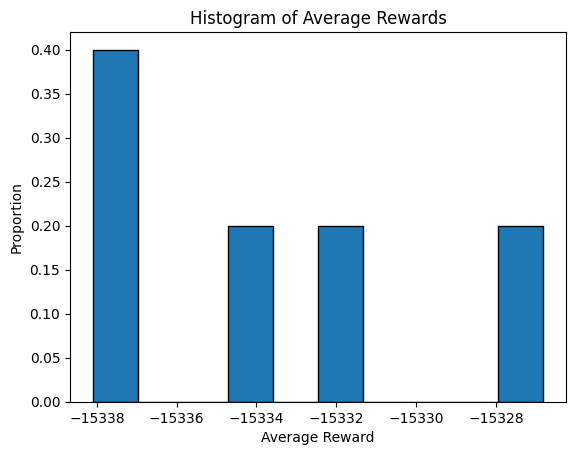

In [8]:
def evaluate_agent_rb(agent, env, num_trials, num_runs_per_trial, rules):
    """
    Evaluate the agent's performance over multiple trials.
    
    Parameters:
    - agent: The RL agent
    - env: The environment
    - num_trials: Number of trials
    - num_runs_per_trial: Number of runs per trial
    - best_conditions: Tuple containing the best conditions (cond, wt, no_change_after_lap)
    
    Returns:
    - A list containing the average reward per trial
    """
    avg_rewards_per_trial = []
    trial_rewards = []  # Store rewards for each trial
    
    for trial in range(num_trials):
        total_rewards = 0
        for run in range(num_runs_per_trial):
            state = env.reset()
            env.radius = 900
            state[3] = env.radius
            done = False
            while not done:
                action = agent.actRules(state, rules)
                reward, next_state, done, _ = env.transition(action)
                state = deepcopy(next_state)
                total_rewards += reward
        avg_reward = total_rewards / num_runs_per_trial
        avg_rewards_per_trial.append(avg_reward)
        trial_rewards.append(total_rewards)  # Store rewards for the current trial
        print(f"Trial {trial + 1}/{num_trials}: Average Reward = {avg_reward}")
    
    return avg_rewards_per_trial, trial_rewards  # Return both average rewards and trial rewards

avg_rewards, trial_rewards = evaluate_agent_rb(agent, env, 5, 100, best_rules)

# Calculate proportions
num_bins = 10
hist, bin_edges = np.histogram(avg_rewards, bins=num_bins)
proportions = hist / len(avg_rewards)  # Normalize by the total number of trials

# Plot histogram of average rewards with proportions
plt.bar(bin_edges[:-1], proportions, width=bin_edges[1] - bin_edges[0], edgecolor='k')
plt.xlabel('Average Reward')
plt.ylabel('Proportion')
plt.title('Histogram of Average Rewards')
plt.show()

#### Final Evaluation using evaluation class for fixed weather and radius

In [9]:
from project_helper_v1 import EvaluationTrack
import pickle

In [10]:
results = pd.DataFrame(columns=['Weather Config','Radius','Rewards'])
model_log = pd.DataFrame(columns=['model_name', 'wc', 'tyre', 'tyre_condition', 'weather_condition', 'radius', 'lap', 'velocity', 'reward'])

j=0

for i in range(81):
    agent = Agent()
    env = EvaluationTrack(car=Car(), weather_config=i, config_fp="weather configuratons.pickle")
    state = env.reset()
    done = False
    G = 0 
    while not done:
        action = agent.actRules(state, best_rules)
        reward, next_state, done, velocity = env.transition(action)
        state = deepcopy(next_state)
        G += reward
        
        tyre = env.car.possible_tyres.index(state[0])
        tyre_condition = state[1]
        weather_condition = env.possible_weather.index(state[2])
        radius = state[3]
        lap = state[4]

        model_log.loc[j, "model_name"] = "rulesbased"
        model_log.loc[j, "wc"] = i
        model_log.loc[j, "tyre"] = tyre
        model_log.loc[j, "tyre_condition"] = tyre_condition
        model_log.loc[j, "weather_condition"] = weather_condition
        model_log.loc[j, "radius"] = radius
        model_log.loc[j, "lap"] = lap
        model_log.loc[j, "velocity"] = velocity
        model_log.loc[j, "reward"] = reward
        j+=1
        
    results.loc[i, "Weather Config"] = i
    results.loc[i, "Radius"] = env.radius
    results.loc[i, "Rewards"] = G

results.to_csv("./eval_rulesbased_radius3.csv", index=False)
model_log.to_csv("./rulesbased_model_log.csv", index=False)